In [2]:
from IPython.display import display, HTML
import sqlite3
import os
from sqlite3 import Error
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import json
import datetime
import pandas as pd
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import plotly.graph_objects as go



#function to create a sqllite db file and returns connection
def create_connection(db_file, delete_db=False):
   if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    
   conn = None
   try:
       conn = sqlite3.connect(db_file)
       conn.execute("PRAGMA foreign_keys = 1")
   except Error as e:
       print(e)
    
   return conn

#function to Create table 
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

#function to drop the table
def drop_table(conn, drop_table_sql):
    try:
        c = conn.cursor()
        c.execute(drop_table_sql)
    except Error as e:
        pass



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
###################################################################################
#processtweetdata reads the tweet data from the dataset and extracts
#User,Tweet and the Tweet date and time
#Inserts formatted data into table
###################################################################################

month_dict={'January':1,
            'February':2,
            'March':3,
            'April':4,
            'May':5,
            'June':6,
            'July':7,
            'August':8,
            'September':9,
            'October':10,
            'November':11,
            'December':12}

#function to read tweets from the file and returns as list
def read_tweetdata(filename):
    tweetlist=list()
    with open(filename, 'r') as json_file:
        json_list = list(json_file)
        
    for each_line in json_list:
        eachtweet = json.loads(each_line)
        eachrec=(eachtweet['UserName'],eachtweet['CreatedAt'],eachtweet['Text'])
        tweetlist.append(eachrec)
        
    return tweetlist


#function to insert tweets into table
def insert_tweetdata(conn, values):
    try:
        sql = ''' INSERT INTO Tweet_Data(ID,User_ID,Tweet_Text,Creation_dt) VALUES(?,?,?,?) '''
        cur = conn.cursor()
        cur.execute(sql, values)
        return cur.lastrowid  
    except Error as e:
        print(e)
  
#function to query all tweets
def query_tweetdata(conn):
    sql = ''' SELECT * FROM Tweet_Data;'''
    cur = conn.cursor()
    cur.execute(sql)
    alltweets = cur.fetchall()

    return alltweets

#Function to query data using pandas
def query_tweetdatapd(conn):
    sql_statement='''SELECT ID,USER_ID,substr(Tweet_Text,1,100) Tweet,Creation_dt FROM Tweet_Data order by Creation_dt limit 5;'''
    df = pd.read_sql_query(sql_statement, conn)
    display(df)

#function to format the tweet date
def get_tweetdate(unformatted):
    timedatasplit=unformatted.split(" ")
    month=month_dict[timedatasplit[0]]
    day=int(timedatasplit[1].strip(','))
    year=int(timedatasplit[2])
    if timedatasplit[4][5:]=="PM" and int(timedatasplit[4][:2])!=12:
        HH=int(timedatasplit[4][:2])+12
    else:
        HH=int(timedatasplit[4][:2])
                
    MM=int(timedatasplit[4][3:5])
    tdate=datetime.datetime(year,month,day,HH,MM)
    return tdate
            
#function to read data from file,pre process and load to database
def processtweetdata(conn,dataset):
    try:
        tweets_list=read_tweetdata(dataset)
        
        drop_table_sql='''DROP TABLE Tweet_Data;'''
        drop_table(conn,drop_table_sql)
        
        tweet_table="CREATE TABLE Tweet_data (ID INTEGER PRIMARY KEY,User_ID TEXT,Tweet_Text TEXT,Creation_dt DATE)"
        create_table(conn,tweet_table)
        
        count=0
        with conn:
            for eachrec in tweets_list:
                tweetdata=(count+1,eachrec[0],eachrec[2],get_tweetdate(eachrec[1]))
                insert_tweetdata(conn,tweetdata)
                count+=1
        
    except Error as e:
        print(e)

In [4]:

def insert_Tesla(conn, values):    
    sql = " INSERT INTO Tesla_Stock VALUES(?,?,?,?,?,?,?); "
    cur = conn.cursor()
    cur.execute(sql,values)
    return cur.lastrowid

#Function to query data using pandas
def query_telsastkdatapd(conn):
    sql_statement='''SELECT Date,Open,Higher,Low,Close,Adj,Volume FROM Tesla_Stock order by Date limit 5;'''
    df = pd.read_sql_query(sql_statement, conn)
    display(df)


def processteslastkdata(conn,dataset):
    try:
        Date =[]
        Op=[]
        Hig=[]
        Lo=[]
        Cl=[]
        AdCl=[]
        Vol=[]
        
        drop_table_sql='''DROP TABLE Tesla_Stock;'''
        drop_table(conn,drop_table_sql)

        create_Tesla_Stock_sql = """CREATE TABLE Tesla_Stock (
                                     Date TEXT  PRIMARY KEY NOT NULL,
                                     Open INTEGER  NOT NULL,
                                     Higher INTEGER   NOT NULL,
                                     Low INTEGER  NOT NULL,
                                     Close INTEGER  NOT NULL,
                                     Adj INTEGER  NOT NULL,
                                     Volume INTEGER    NOT NULL
                                     ); """

        create_table(conn, create_Tesla_Stock_sql)

        df = pd.read_csv(dataset)
        for value in df['Date']:
            Date.append(value)

        for value in df['Open']:
            value = round(value, 2)
            Op.append(value)
                        
        for value in df['High']:
            #print(type(value)) 
            #print(value)
            value = round(value, 2)
           # print(value)
            Hig.append(value)
        for value in df['Low']:
            value = round(value, 2)
            Lo.append(value)
            
        for value in df['Close']:
            value = round(value, 2)
            Cl.append(value)

        for value in df['Adj Close']:
            value = round(value, 2)
            AdCl.append(value)
            
        for value in df['Volume']:
            value = round(value, 2)
            Vol.append(value)

        minjoin = zip(Date,Op,Hig,Lo,Cl,AdCl,Vol)
        with conn:
            for kol in minjoin:
                insert_Tesla(conn, (kol[0],kol[1],kol[2],kol[3],kol[4],kol[5],kol[6]))        

    except Error as e:
        print(e)


In [5]:

stopwords_english =  stopwords.words('english')
stemmer = PorterStemmer()

emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

def clean_tweets(tweet):
    
    # remove stock market tickers
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove old style retweet text
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
 
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
              word not in emoticons and # remove emoticons
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
    
    list_to_str = ' '.join([str(ele) for ele in tweets_clean])
    
    return list_to_str

In [6]:

analyzer = SentimentIntensityAnalyzer()

def sentimentanalyzer(tweet):
    
    tweet_score = []
    
    score = analyzer.polarity_scores(tweet)
    tweet_score.append(score)
    df = pd.DataFrame(tweet_score)
    
    for i,row in df.iterrows():
        row['neg']=-row['neg']
    
    for i, row in df.iterrows():
        if row['compound']<0:
            row['neg'] = row['neg'] + row['compound']
        elif row['compound'] > 0:
            row['pos'] = row['pos'] + row['compound']
    df.drop('compound', axis = 1, inplace = True)
    for i,rows in df.iterrows():
        if row['pos'] > abs(row['neg']) and row['pos'] > row['neu']:
            return ("positive", row['pos'])
            
        elif abs(row['neg'])>row['pos'] and abs(row['neg']) > row['neu']:
            return ("negative", row['neg'])
            
        else:
            return ("neutral", row['neu'])

In [7]:

#Function to query data using pandas
def query_tweetscoresapd(conn):
    sql_statement='''select t.ID,substr(t.Tweet_Text,1,100) Tweet,t1.Score_Polarity,t1.Score FROM Tweet_data t,Tweet_Scores t1 where t.ID=t1.ID limit 10;'''
    df = pd.read_sql_query(sql_statement, conn)
    display(df)
    
    
def calculatetweetscores(conn):
    
    sql_statement='''DROP TABLE Tweet_Scores;'''
    drop_table(conn,sql_statement)

    sql_statement='''CREATE TABLE Tweet_Scores(ID INTEGER PRIMARY KEY,Score_Polarity TEXT,Score REAL);'''
    create_table(conn,sql_statement)

    df = pd.read_sql_query("SELECT * FROM Tweet_Data", conn)
 
    scores = []
    list_of_tweets = list(df['Tweet_Text'])
    
    for tweet in list_of_tweets:
        processed_data = clean_tweets(tweet)
        sentiment_score = sentimentanalyzer(processed_data)
        scores.append(sentiment_score)

    df1 = pd.DataFrame(scores)
    df1.columns = ['Score_Polarity', 'Score']

    df.drop(['User_ID','Tweet_Text','Creation_dt'],axis=1)
    
    merged_df = df.merge(df1, left_index = True, right_index = True)
    
    merged_df=merged_df.drop(['User_ID','Tweet_Text','Creation_dt'],axis=1)
    merged_df=merged_df.rename_axis(None)
        
    merged_df.to_sql('Tweet_Scores',conn,index=False,if_exists = 'append')



In [10]:
def plotpiechart(conn):
    sql_statement='''SELECT count(1) count 
                       FROM (SELECT t.ID,date(t.Creation_dt) TDate,t.Tweet_Text,t1.Score_Polarity,t1.Score,abs(close-open),
		                       CASE WHEN (close-open)<0 then 'D'
                               WHEN (close-open)>0 then 'I'
                               ELSE 'F'
                                END as stockstatus
	                           FROM Tesla_Stock ts,Tweet_data t,Tweet_Scores t1 where t.ID=t1.ID and date(t.Creation_dt)=ts.Date)
                               WHERE score_polarity=? and stockstatus=?
                               GROUP BY score_polarity,stockstatus'''
                               
    df1=pd.read_sql_query(sql_statement,conn,params=['negative','D'])
    df2=pd.read_sql_query(sql_statement,conn,params=['positive','I'])
    df3=pd.read_sql_query(sql_statement,conn,params=['neutral','F'])
    
    tweet_cnt=[df1['count'].tolist()[0],df2['count'].tolist()[0],df3['count'].tolist()[0]]
    tweet_status=['Negative tweets','Positive tweets','Neutral tweets']
    
    colors = ['orange','springgreen','red']
    patches, texts = plt.pie(tweet_cnt, colors=colors, shadow=True, startangle=90)
    plt.legend(patches, tweet_status, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


def plotdailystkprvar(conn):
    sql_statement='''select date,adj from Tesla_Stock where date>(select min(date(creation_dt)) from tweet_data) order by date;'''
    df=pd.read_sql_query(sql_statement,conn)
    df.set_axis(df['Date'], axis='index', inplace=True)
    df=df.drop(['Date'],axis=1)
    df['Adj'].plot(label='Tesla',figsize=(16,8),title='Tesla Stock Price - 2017 to Current',color='dodgerblue')
    plt.legend()
    plt.show()

def plotscores(conn):
    sql_statement='''select date(creation_dt) Date,score from Tweet_data t,Tweet_Scores t1 where t.ID=t1.ID order by date;'''
    df=pd.read_sql_query(sql_statement,conn)
    df.set_axis(df['Date'], axis='index', inplace=True)
    df=df.drop(['Date'],axis=1)
    df['Score'].plot(label='Tweet Scores',figsize=(16,8),title='Elon Musk Tweet Scores',color='orangered')
    plt.legend()
    plt.show()

def plotfinalinteract(conn):
    
    sql_statement='''select date,adj from Tesla_Stock where date>(select min(date(creation_dt)) from tweet_data) order by date;'''
    df=pd.read_sql_query(sql_statement,conn)

    sql_statement='''SELECT distinct Tdate,Tweet_Text,Score_Polarity,Adj,stockstatus
                      FROM (SELECT date(t.Creation_dt) TDate,t.Tweet_Text,t1.Score_Polarity,t1.Score,ts.Adj,
                              CASE WHEN (close-open)<0 then 'D'
                                   WHEN (close-open)>0 then 'I'
                                   ELSE 'F'
                                   END as stockstatus 
                              FROM Tesla_Stock ts,Tweet_data t,Tweet_Scores t1 where t.ID=t1.ID and date(t.Creation_dt)=ts.Date) 
                             WHERE Score_Polarity=? and stockstatus=? order by TDate;'''

    dfpos=pd.read_sql_query(sql_statement,conn,params=['positive','I'])
    dfneg=pd.read_sql_query(sql_statement,conn,params=['negative','D'])
    
    fig = go.Figure(layout_title_text="Tesla Stock Prices v/s Elon Musk Tweets Sentiments")
    
    fig.add_trace(go.Scatter(x=df["Date"].tolist(), y=df["Adj"].tolist(),
                    mode='lines',
                    name='Tesla Stock Price',
                    line = dict(color='rgb(102,102,102)')
                    ))
      
    fig.add_trace(go.Scatter(
        x=dfpos["TDate"],
        y=dfpos["Adj"],
        hovertext=dfpos["Tweet_Text"].tolist(),
        hoverinfo="text",
        mode='markers',
        name='PositiveTweet',
        marker=dict(
            color="#00CC96"
        ),
        showlegend=True
    ))
        
    fig.add_trace(go.Scatter(
        x=dfneg["TDate"],
        y=dfneg["Adj"],
        hovertext=dfneg["Tweet_Text"].tolist(),
        hoverinfo="text",
        mode='markers',
        name='NegativeTweet',
        marker=dict(
            color="#E45756"
        ),
        showlegend=True
    ))
    
    
    fig.show()
    
def plotstatisticssa(conn):
    sql_statement='''SELECT score_polarity,stockstatus,count(1) total 
                       FROM (SELECT distinct Tdate,Tweet_Text,Score_Polarity,Adj,stockstatus
                               FROM (SELECT date(t.Creation_dt) TDate,t.Tweet_Text,t1.Score_Polarity,t1.Score,ts.Adj,
                               CASE WHEN (close-open)<0 then 'D'
                               WHEN (close-open)>0 then 'I'
                               ELSE 'F'
                               END as stockstatus 
                               FROM Tesla_Stock ts,Tweet_data t,Tweet_Scores t1 
                               WHERE t.ID=t1.ID and date(t.Creation_dt)=ts.Date)) 
                      GROUP BY score_polarity,stockstatus;'''
                      
                      
    df=pd.read_sql_query(sql_statement,conn)
    incdata=df[df["stockstatus"]=="I"]
    decdata=df[df["stockstatus"]=="D"]
    flatdata=df[df["stockstatus"]=="F"]
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=incdata["Score_Polarity"].tolist(),
        y=incdata["total"].tolist(),
        name='Rise in Stock Price',
        marker_color='rgb(139,224,164)'
    ))
    fig.add_trace(go.Bar(
        x=decdata["Score_Polarity"].tolist(),
        y=decdata["total"].tolist(),
        name='Fall in Stock Price',
        marker_color='rgb(237,100,90)'
    ))
    fig.add_trace(go.Bar(
        x=flatdata["Score_Polarity"].tolist(),
        y=flatdata["total"].tolist(),
        name='No Change in Stock Price',
        marker_color='rgb(158,185,243)'
    ))
    
    fig.update_layout(barmode='group',title_text='Statistics of Tweet Sentiment v/s Fluctuations',uniformtext_minsize=12, uniformtext_mode='hide')
    fig.show()
    
def plotstatisticssayear(conn):
    sql_statement='''SELECT strftime('%Y',Tdate) year,score_polarity,stockstatus,count(1) total 
						   FROM (SELECT distinct Tdate,Tweet_Text,Score_Polarity,Adj,stockstatus
								   FROM (SELECT date(t.Creation_dt) TDate,t.Tweet_Text,t1.Score_Polarity,t1.Score,ts.Adj,
								   CASE WHEN (close-open)<0 then 'D'
								   WHEN (close-open)>0 then 'I'
								   ELSE 'F'
								   END as stockstatus 
								   FROM Tesla_Stock ts,Tweet_data t,Tweet_Scores t1 
								   WHERE t.ID=t1.ID and date(t.Creation_dt)=ts.Date)) 
						  GROUP BY year,score_polarity,stockstatus;'''
    df=pd.read_sql_query(sql_statement,conn)
    incdata=df[df["stockstatus"]=="I"]
    decdata=df[df["stockstatus"]=="D"]
    flatdata=df[df["stockstatus"]=="F"]
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(x=incdata["year"].tolist(),
					y=incdata["total"].tolist(),
					name='Rise in Stock Price',
					marker_color='rgb(139,224,164)'
					))
    
    fig.add_trace(go.Bar(x=decdata["year"].tolist(),
					y=decdata["total"].tolist(),
					name='Fall in Stock Price',
					marker_color='rgb(237,100,90)'
					))
    
    fig.add_trace(go.Bar(x=flatdata["year"].tolist(),
					y=flatdata["total"].tolist(),
					name='No change in Stock Price',
					marker_color='rgb(158,185,243)'
					))
    
    fig.update_layout(
		title='Statistics of Stock Price Fluctuations by year',
		xaxis_tickfont_size=14,
		yaxis=dict(
			title='Total',
			titlefont_size=16,
			tickfont_size=14,
		),
		legend=dict(
			x=0,
			y=1.0,
			bgcolor='rgba(255, 255, 255, 0)',
			bordercolor='rgba(255, 255, 255, 0)'
		),
		barmode='group',
		bargap=0.15, 
		bargroupgap=0.1 
	)
    
    fig.show()

,ID,User_ID,Tweet,Creation_dt
0,1,elonmusk,@highqualitysh1t I love the thought of a car d...,2017-12-02 19:33:00
1,2,elonmusk,@novaspivack Asimov's Foundation books should ...,2017-12-02 22:46:00
2,3,elonmusk,@novaspivack That's certainly the right way to...,2017-12-03 12:01:00
3,4,elonmusk,To preserve the transcendent majesty &amp; spe...,2017-12-03 19:05:00
4,5,elonmusk,@harrisonlingren @JW8888888 Busted,2017-12-03 19:07:00


,Date,Open,Higher,Low,Close,Adj,Volume
0,2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300
1,2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100
2,2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800
3,2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800
4,2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900


,ID,Tweet,Score_Polarity,Score
0,1,@highqualitysh1t I love the thought of a car d...,positive,0.8809
1,2,@novaspivack Asimov's Foundation books should ...,neutral,1.0000
2,3,@novaspivack That's certainly the right way to...,neutral,1.0000
3,4,To preserve the transcendent majesty &amp; spe...,neutral,0.7190
4,5,@harrisonlingren @JW8888888 Busted,neutral,1.0000
5,6,@IvanEscobosa Yes,neutral,1.0000
6,7,Hat,neutral,1.0000
7,8,Every 5000th buyer of our boringly boring hat ...,neutral,0.6540
8,9,@TheRealUtkarsh Because it's stupid,negative,-1.5267
9,10,@maralkalajian Maybe,neutral,1.0000


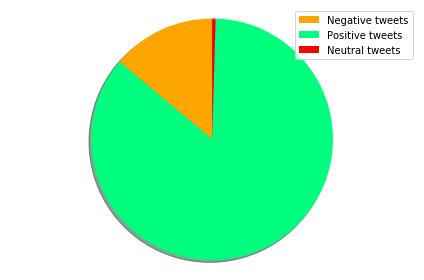

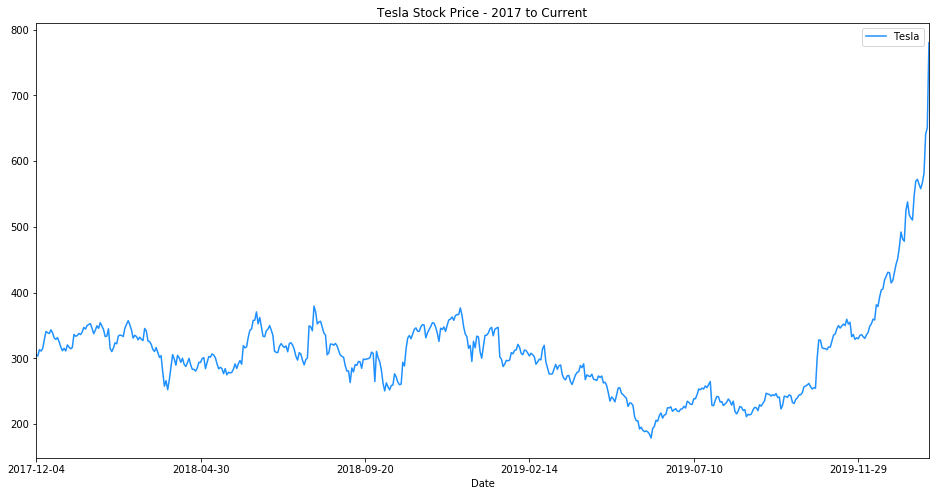

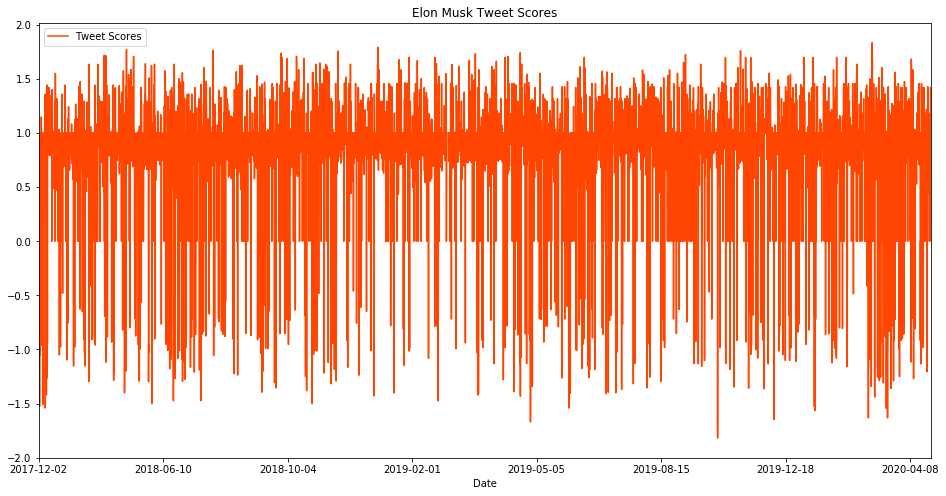

In [11]:
#StartTweetAnalysis - Start function of Project
def maintweetstock():
    elontweetdataset="user-tweets.jsonl"
    teslastockdataset="TSLA.csv"
    dbfile="SentimentAnalysis.db"

    conn= create_connection(dbfile,True)
    try: 
        with conn:
            processtweetdata(conn,elontweetdataset)
            processteslastkdata(conn,teslastockdataset)
            calculatetweetscores(conn)

        conn.commit()

        query_tweetdatapd(conn)
        query_telsastkdatapd(conn)
        query_tweetscoresapd(conn)
        plotpiechart(conn)
        plotdailystkprvar(conn)
        plotscores(conn)
        plotstatisticssa(conn)
        plotstatisticssayear(conn)
        plotfinalinteract(conn)

    except Error as e:
        print(e)
    finally:
        if(conn):
            conn.close()


##Start by calling explicitly
maintweetstock()